In [1]:
%matplotlib inline
! pip install adamp


import numpy as np
from matplotlib import pyplot as plt
import time
import torch
import os
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tests_hw4 import test_prediction, test_generation
from adamp import AdamP


In [2]:
! nvidia-smi
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device ", device)

Fri Dec  9 11:20:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   23C    P8    14W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# TODO: define other hyperparameters here
config = {
'SEQ_LEN' : 20,
'SEQ_LEN_PROBABILITY' : 0.95,
'SEQ_LEN_STD' : 5,
'NUM_EPOCHS' : 20,
'BATCH_SIZE' : 40,
'EMB_DIM' : 220,
'HIDDEN_SIZE' : 220,
'NUM_LAYERS' : 3,
'DROPOUT' : 0.25,
'LR' : 0.001
}


In [4]:
# load all that we need

dataset = np.load('../dataset/wiki.train.npy', allow_pickle=True)
devset = np.load('../dataset/wiki.valid.npy', allow_pickle=True)
fixtures_pred = np.load('../fixtures/prediction.npz')  # dev
fixtures_gen = np.load('../fixtures/generation.npy')  # dev
fixtures_pred_test = np.load('../fixtures/prediction_test.npz')  # test
fixtures_gen_test = np.load('../fixtures/generation_test.npy')  # test
vocab = np.load('../dataset/vocab.npy')

In [5]:
# data loader

class DataLoaderForLanguageModeling(DataLoader):
    """
        TODO: Define data loader logic here
    """
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset # TODO
        self.batch_size = batch_size # TODO
        self.shuffle = shuffle # TODO         

    def __iter__(self):
        """
            You may implement some of the techniques in https://arxiv.org/pdf/1708.02182.pdf
            example: Variable length backpropagation sequences (Section 4.1)
        """
        # 1. Randomly shuffle all the articles from the WikiText-2 dataset.
        # 2. Concatenate all text in one long string.
        # 3. Group the sequences into batches.
        # 4. Run a loop that returns a tuple of (input, label) on every iteration with yield.


        if self.shuffle:
            np.random.shuffle(self.dataset)

        self.seq_len = config["SEQ_LEN"]

        data = np.concatenate(self.dataset)
        self.line_len =  (len(data)-1)//self.batch_size
        inputs = torch.from_numpy(data[0:self.line_len*self.batch_size].reshape(self.batch_size,-1)).long()
        targets = torch.from_numpy(data[1:self.line_len*self.batch_size+1].reshape(self.batch_size,-1)).long()
        
        i = 0
        curr_seq_len = self.seq_len
        while i + curr_seq_len < inputs.shape[1]:
            input = inputs[:,i:i+curr_seq_len]
            target = targets[:,i:i+curr_seq_len]
            i += curr_seq_len
            yield (input, target)
            curr_seq_len = self.seq_len if np.random.rand() < config['SEQ_LEN_PROBABILITY'] else self.seq_len//2
            curr_seq_len_temp = int(np.random.normal(curr_seq_len, config['SEQ_LEN_STD']))
            curr_seq_len = curr_seq_len_temp if curr_seq_len_temp > 0 else curr_seq_len


        # # TEST       
# test = DataLoaderForLanguageModeling(dataset, config['BATCH_SIZE'], config['SEQ_LEN'])
# for i,(test_inputs, test_targets) in enumerate(test.__iter__()):
#     print('---------')
#     print('iter: ', i)
#     print('shape: ', test_inputs.shape)
#     print('type: ', test_inputs.dtype, ', ', test_targets.dtype)
#     for batch_idx in range(0, test.batch_size):
#         tmpstr1 = ['    ']
#         tmpstr2 = ['    ']
#         for seq_idx in range(0, test.seq_len):
#             tmpstr1.append(vocab[test_inputs[batch_idx, seq_idx]])
#             tmpstr2.append(vocab[test_targets[batch_idx, seq_idx]])
#         print(' '.join(tmpstr1))
#         print(' '.join(tmpstr2))
#         print()
#     if(i > 3):
#         break
        

In [6]:
# model

class Model(nn.Module):
    """
        TODO: Define your model here
    """
    def __init__(self, vocab_size:int, embedding_dim:int, hidden_size:int):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,hidden_size,num_layers=config['NUM_LAYERS'], 
          dropout=config['DROPOUT'], batch_first=True)

        self.classifier = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # Feel free to add extra arguments to forward (like an argument to pass in the hiddens)
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.classifier(x)
        
        return x, _

#   # TEST
# model = Model(len(vocab), config['EMB_DIM'], config['HIDDEN_SIZE'])
# test_input = torch.randint(0, len(vocab), (config['BATCH_SIZE'], config['SEQ_LEN']), dtype=torch.long)
# test_output, test_hidden = model(test_input)
# print('Input : ', test_input.shape, ', ', test_input.dtype)
# print('Output: ', test_output.shape, ', ', test_output.dtype) # (batch, seq_len, vocab_size)


In [7]:
# model trainer

class Trainer:
    def __init__(self, model, loader, max_epochs=1, run_id='exp'):
        """
            Use this class to train your model
        """
        # feel free to add any other parameters here
        self.model = model
        self.loader = loader
        self.train_losses = []
        self.val_losses = []
        self.predictions = []
        self.predictions_test = []
        self.generated_logits = []
        self.generated = []
        self.generated_logits_test = []
        self.generated_test = []
        self.epochs = 0
        self.max_epochs = max_epochs
        self.run_id = run_id
        
        # TODO: Define your optimizer and criterion here
        # feel free to define a learning rate scheduler as well if you want
        self.optimizer = AdamP(model.parameters(), lr=config['LR']) #let's try AdamP
        self.criterion = nn.CrossEntropyLoss()

    def train(self):
        self.model.train() # set to training mode
        epoch_loss = 0
        num_batches = 0
        for batch_num, (inputs, targets) in enumerate(self.loader):
            epoch_loss += self.train_batch(inputs, targets)
        epoch_loss = epoch_loss / (batch_num + 1)
        print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, epoch_loss))
        self.train_losses.append(epoch_loss.cpu().detach().numpy())

    def train_batch(self, inputs, targets):
        """ 
            TODO: Define code for training a single batch of inputs
            
            :return 
                    (float) loss value
        """
        self.optimizer.zero_grad()
        inputs= inputs.to(device)
        outputs, _ = self.model(inputs)
        targets = targets.to(device)
        loss = self.criterion( outputs.reshape(-1, outputs.shape[2]),
            targets.reshape(-1))

        loss.backward()
        self.optimizer.step()

        return loss

    
    def test(self):
        # don't change these
        self.model.eval() # set to eval mode
        predictions = TestLanguageModel.predict(fixtures_pred['inp'], self.model) # get predictions
        self.predictions.append(predictions)
        generated_logits = TestLanguageModel.generate(fixtures_gen, 10, self.model) # generated predictions for 10 words
        generated_logits_test = TestLanguageModel.generate(fixtures_gen_test, 10, self.model)
        nll = test_prediction(predictions, fixtures_pred['out'])
        generated = test_generation(fixtures_gen, generated_logits, vocab)
        generated_test = test_generation(fixtures_gen_test, generated_logits_test, vocab)
        self.val_losses.append(nll)
        
        self.generated.append(generated)
        self.generated_test.append(generated_test)
        self.generated_logits.append(generated_logits)
        self.generated_logits_test.append(generated_logits_test)
        
        # generate predictions for test data
        predictions_test = TestLanguageModel.predict(fixtures_pred_test['inp'], self.model) # get predictions
        self.predictions_test.append(predictions_test)
            
        print('[VAL]  Epoch [%d/%d]   Loss: %.4f'
                      % (self.epochs + 1, self.max_epochs, nll))
        self.epochs += 1

        return nll

    def save(self):
        # don't change these
        model_path = os.path.join('experiments', self.run_id, 'model-{}.pkl'.format(self.epochs))
        torch.save({'state_dict': self.model.state_dict()},
            model_path)
        np.save(os.path.join('experiments', self.run_id, 'predictions-{}.npy'.format(self.epochs)), self.predictions[-1])
        np.save(os.path.join('experiments', self.run_id, 'predictions-test-{}.npy'.format(self.epochs)), self.predictions_test[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-{}.npy'.format(self.epochs)), self.generated_logits[-1])
        np.save(os.path.join('experiments', self.run_id, 'generated_logits-test-{}.npy'.format(self.epochs)), self.generated_logits_test[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated[-1])
        with open(os.path.join('experiments', self.run_id, 'generated-{}-test.txt'.format(self.epochs)), 'w') as fw:
            fw.write(self.generated_test[-1])


In [8]:
class TestLanguageModel:
    def predict(inp, model):
        """
            TODO: write prediction code here
            
            :param inp:
            :return: a np.ndarray of logits
        """
        
        outputs, _ = model(torch.Tensor(inp).long().to(device))
        pred = (outputs[:,-1,:]).cpu().detach().numpy()

        return pred

        
    def generate(inp, forward, model):
        """
            TODO: write generation code here

            Generate a sequence of words given a starting sequence.
            :param inp: Initial sequence of words (batch size, length)
            :param forward: number of additional words to generate
            :return: generated words (batch size, forward)
        """        
        generated_words = []
        temp_inp = torch.clone(torch.Tensor(inp).long())
        for i in range(forward):
            out, _ = model(temp_inp.to(device))
            temp_words = torch.argmax(out, dim=2)[:,-1]
            generated_words.append(temp_words)
            temp_inp = torch.unsqueeze(temp_words, dim=1)
        generated_words = (torch.stack(generated_words, dim=1)).cpu().detach().numpy()

        return generated_words


# # TEST
# test_input = torch.randint(0, len(vocab), (config['BATCH_SIZE'], config['SEQ_LEN']))
# test_model = Model(len(vocab), config['EMB_DIM'], config['HIDDEN_SIZE']).to(device)
# test_output = TestLanguageModel.predict(test_input, test_model)
# print('Test predict : ', test_output.shape)
# test_output = TestLanguageModel.generate(test_input, 20, test_model)
# print('Test generate: ', test_output.shape)

In [9]:
run_id = str(int(time.time()))
if not os.path.exists('./experiments'):
    os.mkdir('./experiments')
os.mkdir('./experiments/%s' % run_id)
print("Saving models, predictions, and generated words to ./experiments/%s" % run_id)

Saving models, predictions, and generated words to ./experiments/1670584851


In [10]:
model = Model(len(vocab), embedding_dim=config['EMB_DIM'], hidden_size=config['HIDDEN_SIZE']).to(device)

loader = DataLoaderForLanguageModeling(
    dataset=dataset, 
    batch_size=config['BATCH_SIZE'], 
    shuffle=True
)
trainer = Trainer(
    model=model, 
    loader=loader, 
    max_epochs=config['NUM_EPOCHS'], 
    run_id=run_id
)   

In [11]:
best_nll = 1e30 
print('best_nll is ', best_nll)
for epoch in range(config['NUM_EPOCHS']):
    print('Epoch: ', epoch+1, '/', config['NUM_EPOCHS'])
    trainer.train()
    nll = trainer.test()
    if nll < best_nll:
        best_nll = nll
        print("Saving model, predictions and generated output for epoch "+str(epoch)+" with NLL: "+ str(best_nll))
        trainer.save()
    

best_nll is  1e+30
Epoch:  1 / 20
[TRAIN]  Epoch [1/20]   Loss: 6.7068
[VAL]  Epoch [1/20]   Loss: 5.6673
Saving model, predictions and generated output for epoch 0 with NLL: 5.667307
Epoch:  2 / 20
[TRAIN]  Epoch [2/20]   Loss: 5.9383
[VAL]  Epoch [2/20]   Loss: 5.2113
Saving model, predictions and generated output for epoch 1 with NLL: 5.2112675
Epoch:  3 / 20
[TRAIN]  Epoch [3/20]   Loss: 5.6277
[VAL]  Epoch [3/20]   Loss: 5.0013
Saving model, predictions and generated output for epoch 2 with NLL: 5.001272
Epoch:  4 / 20
[TRAIN]  Epoch [4/20]   Loss: 5.4237
[VAL]  Epoch [4/20]   Loss: 4.9130
Saving model, predictions and generated output for epoch 3 with NLL: 4.9129887
Epoch:  5 / 20
[TRAIN]  Epoch [5/20]   Loss: 5.2690
[VAL]  Epoch [5/20]   Loss: 4.8172
Saving model, predictions and generated output for epoch 4 with NLL: 4.8172054
Epoch:  6 / 20
[TRAIN]  Epoch [6/20]   Loss: 5.1369
[VAL]  Epoch [6/20]   Loss: 4.7407
Saving model, predictions and generated output for epoch 5 with NL

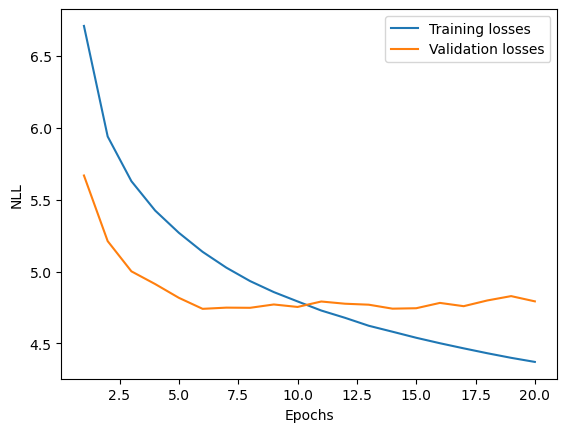

In [12]:
# Don't change these
# plot training curves
plt.figure()
plt.plot(range(1, trainer.epochs + 1), trainer.train_losses, label='Training losses')
plt.plot(range(1, trainer.epochs + 1), trainer.val_losses, label='Validation losses')
plt.xlabel('Epochs')
plt.ylabel('NLL')
plt.legend()
plt.show()

In [13]:
# see generated output
print (trainer.generated[-1]) # get last generated output

Input | Output #0: while the group was en route , but only three were ultimately able to attack . None of them were | ordered to the <unk> , and the <unk> , and
Input | Output #1: <unk> , where he remained on loan until 30 June 2010 . <eol> = = = Return to Manchester United | = = = = = = = = = =
Input | Output #2: 25 April 2013 , denoting shipments of 500 @,@ 000 copies . <eol> The song became One Direction 's fourth | single , and the <unk> , and the <unk> ,
Input | Output #3: , and Bruce R. ) one daughter ( Wendy J. <unk> ) and two grandchildren , died in <unk> , | <unk> , and the <unk> , and the <unk> ,
Input | Output #4: Warrior were examples of this type . Because their armor was so heavy , they could only carry a single | screw <unk> , and the <unk> , and the <unk>
Input | Output #5: the embassy at 1 : 49 and landed on Guam at 2 : 23 ; twenty minutes later , Ambassador | , and the <unk> , and the <unk> , and
Input | Output #6: <unk> , $ 96 million USD ) . Damage was heaviest in S